### 1 Data Mining

#### 1.1 Rent Data

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time
import re
from time import sleep
from scipy import stats
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [12]:
def extract_area_from_info(info_text):
    """Extract area value from housing information text"""
    # Match pattern: number + ㎡
    area_match = re.search(r'(\d+(?:\.\d+)?)\s*㎡', info_text)
    area = area_match.group(1) if area_match else None
    return area

def extract_price(price_text):
    """Extract price value from price text"""
    # Match price numbers
    price_match = re.search(r'(\d+(?:\.\d+)?)', price_text)
    price = price_match.group(1) if price_match else None
    return price

In [13]:
# Set up browser driver
driver = webdriver.Chrome()
url = 'https://zu.fang.com/house-a012-b01182/'
# url = 'https://zu.fang.com/house-a012-b02697/'    #huoying
driver.get(url)
sleep(3)

all_data = []
num_pages = 20

In [15]:
for page in range(num_pages):
    print(f"Currently scraping page {page + 1}...")
    
    try:
        houses = driver.find_elements(By.CSS_SELECTOR, '#listBox > div.houseList > dl')
        
        for i, house in enumerate(houses):
            try:
                # Locate price element using class="price"
                price_element = house.find_element(By.CSS_SELECTOR, 'span.price')
                price_text = price_element.text
                price = extract_price(price_text)
                
                # Extract complete housing information (including area, layout, orientation, etc.)
                info_element = house.find_element(By.CSS_SELECTOR, 'dd > p.font15.mt12.bold')
                info_text = info_element.text
                
                # Extract area value from complete information
                area = extract_area_from_info(info_text)
                
                # Only keep price and area values
                if price and area:
                    house_data = {
                        'price': float(price),
                        'area': float(area)
                    }
                    all_data.append(house_data)
                else:
                    print(f"Page {page+1} item {i+1}: Incomplete data, skipping")
                
            except NoSuchElementException as e:
                print(f"Page {page+1} item {i+1} housing information incomplete: {e}")
                continue
                
    except NoSuchElementException:
        print("No housing list found")
        break
    
    # Click next page
    try:
        next_links = driver.find_elements(By.XPATH, "//a[contains(text(), '下一页')]")
        if next_links:
            next_links[0].click()
            sleep(3)
        else:
            print("No more pages")
            break
    except Exception as e:
        print(f"Unable to click next page: {e}")
        break

Currently scraping page 1...
Currently scraping page 2...
Currently scraping page 3...
Currently scraping page 4...
Currently scraping page 5...
Currently scraping page 6...
Currently scraping page 7...
Currently scraping page 8...
Currently scraping page 9...
Currently scraping page 10...
Currently scraping page 11...
Currently scraping page 12...
Currently scraping page 13...
Currently scraping page 14...
Currently scraping page 15...
Currently scraping page 16...
Currently scraping page 17...
Currently scraping page 18...
Currently scraping page 19...
Currently scraping page 20...


In [16]:
driver.quit()
df = pd.DataFrame(all_data)
print(f"\n Finish! {len(df)} items in total.")


 Finish! 1546 items in total.


In [17]:
# Save as CSV format
csv_filename = 'rent_huilongguan.csv'
# csv_filename = 'rent_huoying.csv'
df.to_csv(csv_filename, index=False)

#### 1.2 Sale Data

In [21]:
# Sale information for scraping
regions = [
    {
        'name': 'huilongguan',
        'url': 'https://esf.fang.com/house-a012-b01182/',
        'filename': 'sale_huilongguan.csv'
    },
    {
        'name': 'huoying', 
        'url': 'https://esf.fang.com/house-a012-b02697/',
        'filename': 'sale_huoying.csv'
    }
]

# Select the region to scrape
current_region = regions[1]
print(f"Preparing to scrape region: {current_region['name']}")

# Set up browser driver and open web page
driver = webdriver.Chrome()
url = current_region['url']
driver.get(url)    # Navigate to the target URL

# Wait for page to load completely
sleep(3)

Preparing to scrape region: huoying


In [22]:
# Crawl the currently opened page
def crawl_current_page(driver, region_name, num_pages=20):
    """Crawl data from the currently opened browser page"""
    print(f"\nStarting to crawl data for {region_name} region...")    
    all_data = []
    
    for page in range(num_pages):
        print(f"\n{region_name} - Currently scraping page {page + 1}...")
        time.sleep(3)
        
        try:
            # Use more flexible selector
            house_list = driver.find_element(By.CLASS_NAME, 'shop_list')
            houses = house_list.find_elements(By.TAG_NAME, 'dl')            
            page_data_count = 0    # Count valid data records on this page
            
            for i, house in enumerate(houses):
                try:
                    # Price information
                    price_elements = house.find_elements(By.CSS_SELECTOR, "dd.price_right span.red b")
                    price_text = price_elements[0].text.strip() if price_elements else None
                    price = extract_price(price_text) if price_text else None
                    
                    # Area information
                    tel_shop_elements = house.find_elements(By.CLASS_NAME, 'tel_shop')
                    area = None
                    
                    # Iterate through all tel_shop elements to extract area
                    for tel_shop_element in tel_shop_elements:
                        tel_shop_text = tel_shop_element.text.strip()
                        if tel_shop_text:
                            area = extract_area_from_info(tel_shop_text)
                            if area:    # Stop searching if area is found
                                break
                    
                    # If area not found with above method, try extracting from full house element text
                    if not area:
                        full_text = house.text
                        area = extract_area_from_info(full_text)
                    
                    # Only keep price and area values
                    if price and area:
                        house_data = {
                            'price': float(price),
                            'area': float(area)
                        }
                        all_data.append(house_data)
                        page_data_count += 1
                    else:
                        print(f"{region_name} - Page {page+1} item {i+1}: Incomplete data - Price:{price}, Area:{area}")
                        
                except Exception as e:
                    print(f"{region_name} - Error parsing item {i+1}: {e}")
                    continue
                    
            print(f"{region_name} - Page {page+1} collected {page_data_count} valid records")
                    
        except Exception as e:
            print(f"{region_name} - Error finding house list: {e}")
            break
            
        # Click next page
        if page < num_pages - 1:
            try:
                # Wait for "Next page" button to appear and be clickable
                next_button = WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.XPATH, '//*[text()="下一页" or contains(text(),"下一页")]'))
                )

                # Click the button
                next_button.click()
                print(f"{region_name} - Successfully clicked next page")

                # Wait for new page to load
                time.sleep(2.5)

            except Exception as e:
                print(f"{region_name} - Error clicking next page: {e}")
                # If "Next page" not found, it might be the last page, break loop
                try:
                    # Try again to check if "Next page" exists
                    if not driver.find_elements(By.XPATH, '//*[contains(text(),"下一页")]'):
                        print(f"{region_name} - No more pages")
                        break
                except:
                    print(f"{region_name} - Page structure abnormal or loading failed")
                break
                
    return all_data

# Start crawling current page
region_data = crawl_current_page(driver, current_region['name'], num_pages=20)


Starting to crawl data for huoying region...

huoying - Currently scraping page 1...
huoying - Page 1 collected 60 valid records
huoying - Successfully clicked next page

huoying - Currently scraping page 2...
huoying - Page 2 collected 60 valid records
huoying - Successfully clicked next page

huoying - Currently scraping page 3...
huoying - Page 3 collected 60 valid records
huoying - Successfully clicked next page

huoying - Currently scraping page 4...
huoying - Page 4 collected 60 valid records
huoying - Successfully clicked next page

huoying - Currently scraping page 5...
huoying - Page 5 collected 60 valid records
huoying - Successfully clicked next page

huoying - Currently scraping page 6...
huoying - Page 6 collected 60 valid records
huoying - Successfully clicked next page

huoying - Currently scraping page 7...
huoying - Page 7 collected 60 valid records
huoying - Successfully clicked next page

huoying - Currently scraping page 8...
huoying - Page 8 collected 39 valid rec

Huoying has less than 20 pages for both sale and rent data.

In [23]:
# Save data and close browser
def save_data_and_close(region_data, region_info, driver):
    """Save scraped data and close browser"""
    if region_data:
        df = pd.DataFrame(region_data)
        print(f"\n{region_info['name']} - Scraping completed! Total records: {len(df)}")
        
        # Save data as CSV format only
        csv_filename = region_info['filename']
        df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
        print(f"Data saved as: {csv_filename}")
        
    else:
        print(f"{region_info['name']} - No data was scraped")
    
    # Close browser
    if driver:
        driver.quit()
        print(f"Browser closed")

# Save data and close browser
save_data_and_close(region_data, current_region, driver)


huoying - Scraping completed! Total records: 459
Data saved as: sale_huoying.csv
Browser closed


### 2 Data Research

#### 2.1 Load and merge the data

In [31]:
# Preview CSV headers
rent_files = [
    "rent_huilongguan.csv",
    "rent_huoying.csv",
    "rent_shahe.csv",
    "rent_tiantongyuan.csv"
]

sale_files = [
    "sale_huilongguan.csv",
    "sale_huoying.csv",
    "sale_shahe.csv",
    "sale_tiantongyuan.csv"
]

# Preview the first few rows of each file to check column headers
for file in rent_files + sale_files:
    print(f"\nPreview: {os.path.basename(file)}")
    try:
        temp = pd.read_csv(file, nrows=5)
        display(temp.head())
    except Exception as e:
        print(f"Error reading {file}: {e}")


Preview: rent_huilongguan.csv


,price,area
0,18000.0,224.0
1,1900.0,15.0
2,5900.0,116.0
3,2200.0,20.0
4,2800.0,25.0



Preview: rent_huoying.csv


,price,area
0,3900.0,45.0
1,1800.0,17.0
2,1400.0,10.0
3,6300.0,89.0
4,6000.0,86.0



Preview: rent_shahe.csv


,价格,面积
0,3800,86.0
1,3800,76.0
2,1300,74.0
3,1700,76.0
4,3000,80.0



Preview: rent_tiantongyuan.csv


,价格,面积
0,5000,97
1,1550,20
2,5300,96
3,5300,79
4,2020,20



Preview: sale_huilongguan.csv


,price,area
0,814.0,127.0
1,959.0,145.0
2,615.0,101.0
3,385.0,60.0
4,614.0,101.0



Preview: sale_huoying.csv


,price,area
0,680.0,110.39
1,935.0,142.89
2,929.0,146.00
3,319.0,88.74
4,400.0,89.04



Preview: sale_shahe.csv


,价格,面积
0,2980.0,541.00
1,2980.0,541.00
2,156.0,75.00
3,4998.0,768.79
4,5980.0,750.00



Preview: sale_tiantongyuan.csv


,价格,面积
0,1048,211.82
1,1180,238.00
2,246,91.62
3,209,97.49
4,850,186.00


In [32]:
# Standardize column names
def standardize_columns(file):
    """
    Read a CSV file and standardize its column names to 'price' and 'area'.
    Handle different naming conventions across files.
    """
    df = pd.read_csv(file)
    df.columns = df.columns.str.strip()  # Remove extra spaces
    
    rename_dict = {
        "价格": "price",
        "面积": "area"
    }
    
    df = df.rename(columns=rename_dict)
    return df

# Merge rent and sale datasets
def merge_datasets(file_list, data_type):
    """
    Merge multiple standardized CSV files into one DataFrame.
    Add 'block' (district name) and 'data_type' (rent/sale) columns.
    """
    df_list = []

    for file in file_list:
        # Extract district name (e.g. rent_huilongguan.csv -> huilongguan)
        filename = os.path.basename(file)
        district = filename.split('_')[1].replace('.csv', '').lower()

        df = standardize_columns(file)
        df["block"] = district
        df["data_type"] = data_type

        df_list.append(df[["price", "area", "block", "data_type"]])

    merged = pd.concat(df_list, ignore_index=True)
    return merged

In [33]:
# Merge rent and sale datasets
rent_data = merge_datasets(rent_files, "rent")
sale_data = merge_datasets(sale_files, "sale")

# Convert sale price unit: from '10k RMB' to 'RMB'
sale_data["price"] = sale_data["price"] * 10000  

# Display results
print("Sale data combined shape:", sale_data.shape)
display(sale_data.head())

print("Rent data combined shape:", rent_data.shape)
display(rent_data.head())


Sale data combined shape: (4066, 4)


,price,area,block,data_type
0,8140000.0,127.0,huilongguan,sale
1,9590000.0,145.0,huilongguan,sale
2,6150000.0,101.0,huilongguan,sale
3,3850000.0,60.0,huilongguan,sale
4,6140000.0,101.0,huilongguan,sale


Rent data combined shape: (4248, 4)


,price,area,block,data_type
0,18000.0,224.0,huilongguan,rent
1,1900.0,15.0,huilongguan,rent
2,5900.0,116.0,huilongguan,rent
3,2200.0,20.0,huilongguan,rent
4,2800.0,25.0,huilongguan,rent


In [34]:
print("=== Missing Value Check ===")
print("Rent Data Missing Values:")
display(rent_data.isnull().sum())

print("\nSale Data Missing Values:")
display(sale_data.isnull().sum())

print(f"\nRent data shape: {rent_data.shape}")
print(f"Sale data shape: {sale_data.shape}")

=== Missing Value Check ===
Rent Data Missing Values:


price        0
area         0
block        0
data_type    0
dtype: int64


Sale Data Missing Values:


price        0
area         0
block        0
data_type    0
dtype: int64


Rent data shape: (4248, 4)
Sale data shape: (4066, 4)


#### 2.2 Data description and outlier detection

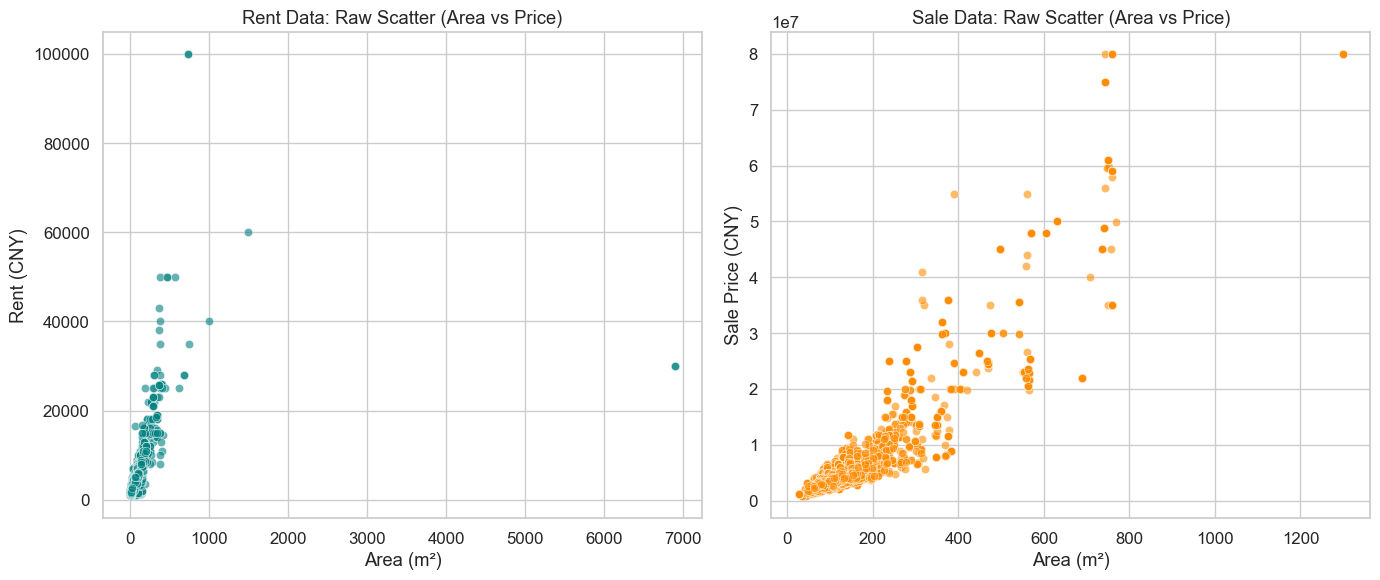

In [35]:
# Visualize Raw Data Before Cleaning
# Scatter plots help identify data distribution and extreme outliers visually
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=rent_data, x="area", y="price", alpha=0.6, ax=axes[0], color="teal")
axes[0].set_title("Rent Data: Raw Scatter (Area vs Price)")
axes[0].set_xlabel("Area (m²)")
axes[0].set_ylabel("Rent (CNY)")

sns.scatterplot(data=sale_data, x="area", y="price", alpha=0.6, ax=axes[1], color="darkorange")
axes[1].set_title("Sale Data: Raw Scatter (Area vs Price)")
axes[1].set_xlabel("Area (m²)")
axes[1].set_ylabel("Sale Price (CNY)")

plt.tight_layout()
plt.show()

In [36]:
# Remove Unreasonable Outliers
def clean_real_estate_data(df, price_col, area_col, price_cap, area_min=10, area_max=400):
    """
    Clean real estate data by removing physically unreasonable or extreme records.
    
    Rationale:
    - Some outliers come from input errors or very special cases.
    - We define "reasonable" ranges based on domain knowledge of residential housing.
      eg.
        • Area < 10 m² → likely input error or non-livable space
        • Area > 400 m² → likely villa or commercial property
        • Price > threshold → extreme luxury listings distort regression
    """
    df_clean = df.copy()
    df_clean = df_clean[(df_clean[price_col] > 0) & (df_clean[area_col] > 0)]
    df_clean = df_clean[(df_clean[area_col] >= area_min) & (df_clean[area_col] <= area_max)]
    df_clean = df_clean[df_clean[price_col] <= price_cap]
    return df_clean

# Apply filters
rent_data_clean = clean_real_estate_data(rent_data, "price", "area", price_cap=300000)
sale_data_clean = clean_real_estate_data(sale_data, "price", "area", price_cap=50000000)

print(f"Original rent data: {len(rent_data)} rows → Cleaned: {len(rent_data_clean)} rows")
print(f"Original sale data: {len(sale_data)} rows → Cleaned: {len(sale_data_clean)} rows")

Original rent data: 4248 rows → Cleaned: 4197 rows
Original sale data: 4066 rows → Cleaned: 3511 rows


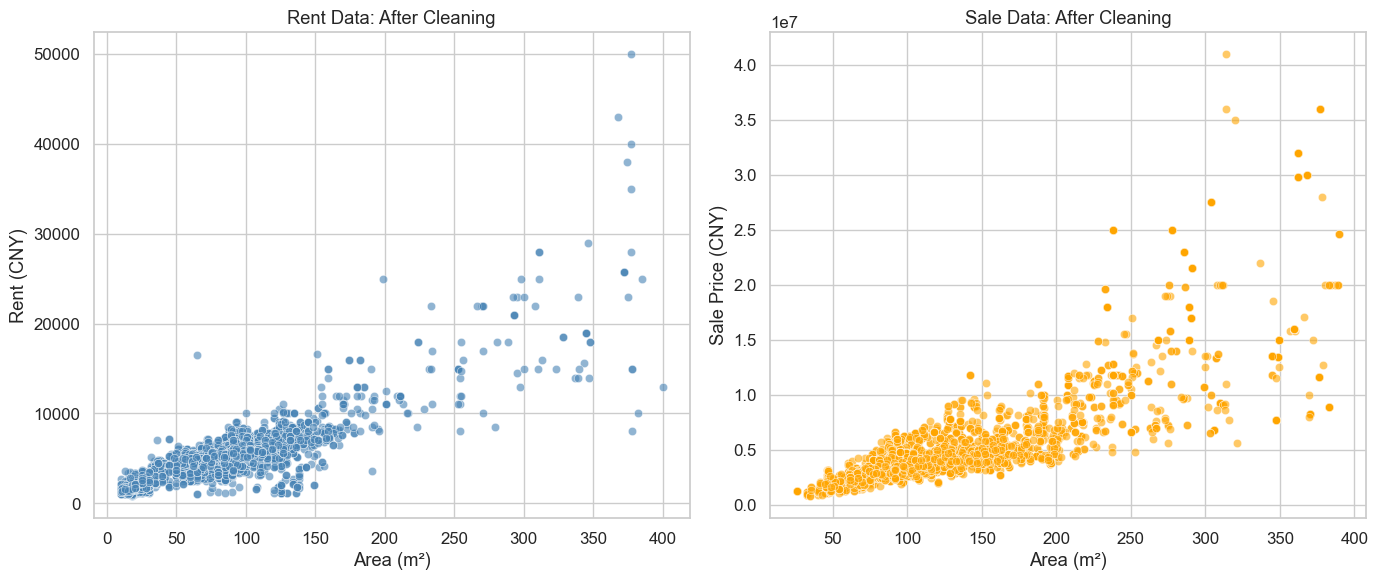

In [37]:
# Visualize Cleaned Data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=rent_data_clean, x="area", y="price", alpha=0.6, ax=axes[0], color="steelblue")
axes[0].set_title("Rent Data: After Cleaning")
axes[0].set_xlabel("Area (m²)")
axes[0].set_ylabel("Rent (CNY)")

sns.scatterplot(data=sale_data_clean, x="area", y="price", alpha=0.6, ax=axes[1], color="orange")
axes[1].set_title("Sale Data: After Cleaning")
axes[1].set_xlabel("Area (m²)")
axes[1].set_ylabel("Sale Price (CNY)")

plt.tight_layout()
plt.show()

#### 2.3 Compute price/m² and rent/m²

In [38]:
rent_data_clean["rent_per_m2"] = rent_data_clean["price"] / rent_data_clean["area"]
sale_data_clean["price_per_m2"] = sale_data_clean["price"] / sale_data_clean["area"]

#### 2.4 Per-block data description, outlier detection, and median price-to-rent ratio

2.4.1 Outlier Detection and Cleaning by Block

In [39]:
# Data Description Function (by block)
def describe_data_by_block(df, value_col):
    print(f"\n=== Descriptive Statistics for {value_col} by Block ===")
    desc = df.groupby("block")[value_col].describe().round(2)
    display(desc)

print("Describe rent data by block")
describe_data_by_block(rent_data_clean, "rent_per_m2")
print("\nDescribe sale data by block")
describe_data_by_block(sale_data_clean, "price_per_m2")

Describe rent data by block

=== Descriptive Statistics for rent_per_m2 by Block ===


,count,mean,std,min,25%,50%,75%,max
block,,,,,,,,
huilongguan,1191.0,79.85,29.94,8.82,60.25,74.71,90.00,276.92
huoying,643.0,79.53,22.78,10.00,66.26,73.08,88.33,190.91
shahe,1185.0,56.87,19.63,11.20,45.88,52.50,62.86,194.44
tiantongyuan,1178.0,72.46,29.87,13.42,53.12,61.44,87.50,210.00



Describe sale data by block

=== Descriptive Statistics for price_per_m2 by Block ===


,count,mean,std,min,25%,50%,75%,max
block,,,,,,,,
huilongguan,1186.0,41286.21,11832.01,21142.86,32606.48,38883.16,48650.07,95574.38
huoying,466.0,42499.58,9718.01,16509.04,36749.69,40948.13,47481.42,68882.18
shahe,659.0,53465.06,22943.82,20370.37,37373.74,49806.31,73850.17,130573.25
tiantongyuan,1200.0,32597.83,7717.26,16671.81,27553.16,31611.35,36060.41,84214.14


In [40]:
# Robust Z-score Outlier Detection (block-wise)
def detect_outliers_by_block(df, value_col, threshold=3.5):
    """
    Since datasets exhibit right-skewed distributions, using Robust Z-score to handle outliers.
    Detect outliers in each block using Robust Z-score method.
    For each block, compute median and MAD separately to account for different price levels.
    """
    df = df.copy()
    df["robust_z"] = np.nan
    
    for block, subset in df.groupby("block"):
        median = subset[value_col].median()
        mad = np.median(np.abs(subset[value_col] - median))
        if mad == 0:  # Avoid division by zero
            continue
        df.loc[subset.index, "robust_z"] = 0.6745 * (subset[value_col] - median) / mad
    
    # Identify outliers
    outliers = df[np.abs(df["robust_z"]) > threshold]
    clean_df = df[np.abs(df["robust_z"]) <= threshold]

    print(f"\nTotal outliers removed (|Z_robust| > {threshold}): {len(outliers)}")
    print(f"Remaining observations: {len(clean_df)}")
    return clean_df, outliers
    
print("\nDetect and remove outliers by block for rent dataset:")
rent_clean, rent_outliers = detect_outliers_by_block(rent_data_clean, "rent_per_m2")
print("\nDetect and remove outliers by block for sale dataset:")
sale_clean, sale_outliers = detect_outliers_by_block(sale_data_clean, "price_per_m2")


Detect and remove outliers by block for rent dataset:

Total outliers removed (|Z_robust| > 3.5): 230
Remaining observations: 3967

Detect and remove outliers by block for sale dataset:

Total outliers removed (|Z_robust| > 3.5): 26
Remaining observations: 3485



Visualize outliers for a selected block in rent dataset


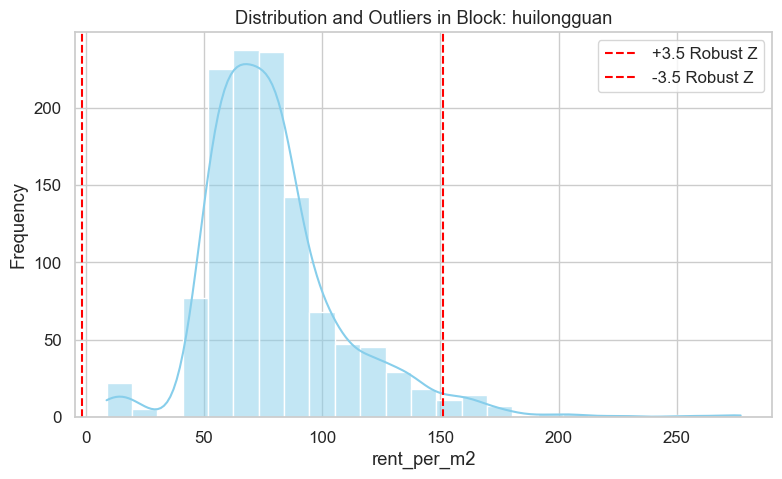


Visualize outliers for a selected block in sale dataset


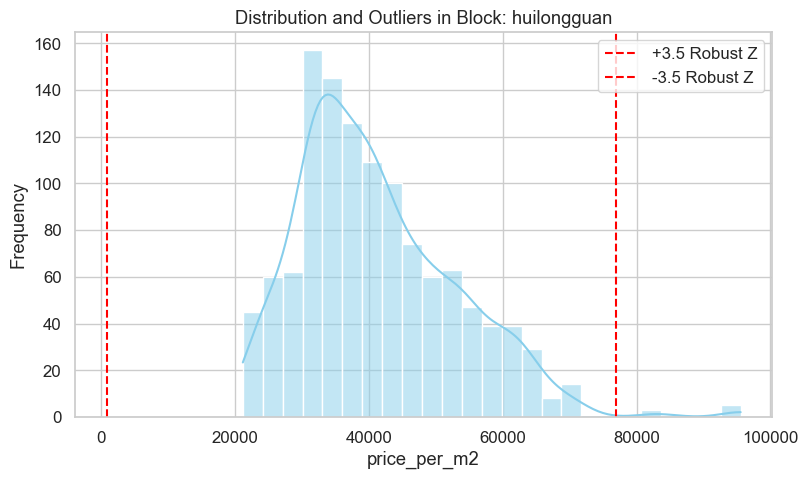

In [41]:
# Visualization of Outliers (per block)
def visualize_outliers_by_block(df, value_col, block_name, threshold=3.5):
    subset = df[df["block"] == block_name]
    if subset.empty:
        print(f"No data for block '{block_name}'")
        return
    
    sns.set_theme(style="whitegrid", font_scale=1.1)
    plt.figure(figsize=(9, 5))
    sns.histplot(subset[value_col], bins=25, kde=True, color="skyblue")
    
    # Draw robust Z thresholds
    median = subset[value_col].median()
    mad = np.median(np.abs(subset[value_col] - median))
    if mad > 0:
        upper = median + (threshold / 0.6745) * mad
        lower = median - (threshold / 0.6745) * mad
        plt.axvline(upper, color="red", linestyle="--", label=f"+{threshold} Robust Z")
        plt.axvline(lower, color="red", linestyle="--", label=f"-{threshold} Robust Z")
    
    plt.title(f"Distribution and Outliers in Block: {block_name}")
    plt.xlabel(value_col)
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
print("\nVisualize outliers for a selected block in rent dataset")
visualize_outliers_by_block(rent_data_clean, "rent_per_m2", block_name="huilongguan", threshold=3.5)
print("\nVisualize outliers for a selected block in sale dataset")
visualize_outliers_by_block(sale_data_clean, "price_per_m2", block_name="huilongguan", threshold=3.5)

2.4.2 Compute median price-to-rent ratio per block

In [42]:
def compute_price_to_rent_ratio(sale_data, rent_data):
    """
    Compute per-block median price per m² and rent per m²,
    then calculate the median price-to-rent ratio for each block.
    """
    median_price = sale_data.groupby("block")["price_per_m2"].median().reset_index()
    median_rent = rent_data.groupby("block")["rent_per_m2"].median().reset_index()

    block_ratio = pd.merge(median_price, median_rent, on="block", how="inner")
    block_ratio["price_to_rent_ratio"] = block_ratio["price_per_m2"] / (block_ratio["rent_per_m2"])

    print("\nMedian Price-to-Rent Ratio by Block:")
    display(block_ratio)
    return block_ratio

In [43]:
# Compute median price-to-rent ratio per block
block_ratio = compute_price_to_rent_ratio(sale_clean, rent_clean)


Median Price-to-Rent Ratio by Block:


,block,price_per_m2,rent_per_m2,price_to_rent_ratio
0,huilongguan,38758.589888,73.827839,524.986110
1,huoying,40948.132366,72.602740,564.002578
2,shahe,48076.923077,51.724138,929.487179
3,tiantongyuan,31573.986805,60.000000,526.233113


#### 2.5 Figure A - Visualization of Price-to-Rent Ratio per block

In [69]:
import warnings
warnings.filterwarnings("ignore")

def plot_price_to_rent_ratio(block_ratio, global_fair_value=200):
    """
    Plot bar chart of median price-to-rent ratio per block,
    with a reference line for global fair value (typically ≈200).
    """
    sns.set_theme(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 6))
    
    # Bar chart
    sns.barplot(
        data=block_ratio,
        x="block",
        y="price_to_rent_ratio",
        hue="block",
        dodge=False,
        legend=False,
        palette="Blues_d"
    )

    # Reference line (global fair value)
    plt.axhline(y=global_fair_value, color="red", linestyle="--", label=f"Global Fair Value ≈ {global_fair_value}")

    plt.title("Median Price-to-Rent Ratio by Block")
    plt.xlabel("Block")
    plt.ylabel("Price-to-Rent Ratio (Annualized)")
    plt.legend()
    plt.tight_layout()
    plt.show()

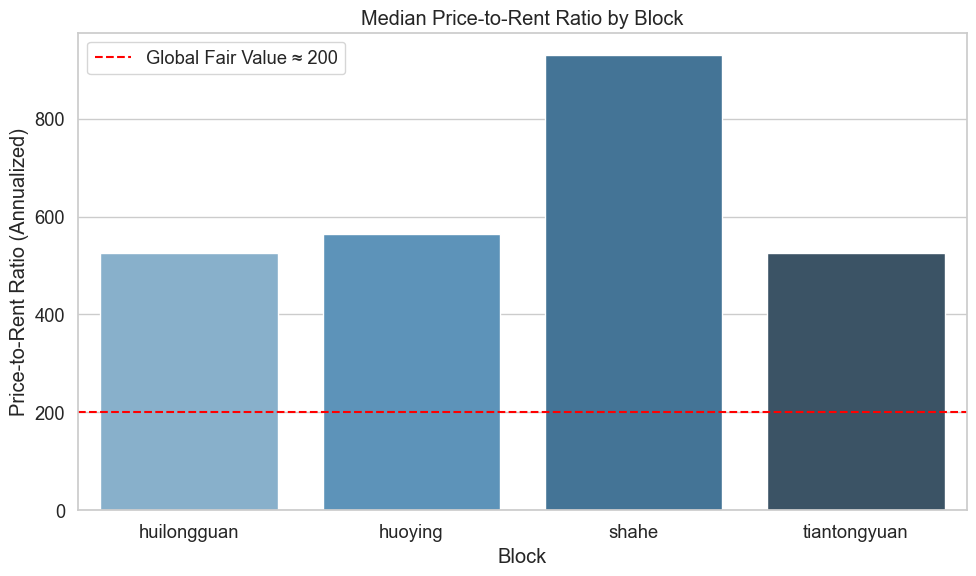

In [70]:
# Visualize the ratios with a global fair value reference line
plot_price_to_rent_ratio(block_ratio, global_fair_value=200)

### 3 Data Science Modeling

In [46]:
# Import necessary libraries
import statsmodels.api as sm

#### 3.1 Build Models
Model 1: price_per_m2 = β0 + β1 * area + β2 * block + ε  
Model 2: rent_per_m2 = β0 + β1 * area + β2 * block + ε

In [47]:
def build_model(df, target_col): 
    """
    Build a linear regression model for the specified target variable 
    and display only key regression statistics and coefficients.
    """
    # Prepare predictor matrix
    X = df[["area", "block"]].copy()

    # Convert 'block' into dummy variables
    X = pd.get_dummies(X, columns=["block"], drop_first=True)

    # Add constant term (intercept)
    X = sm.add_constant(X).astype(float)

    # Define dependent variable
    y = df[target_col].astype(float)

    # Fit the OLS regression model
    model = sm.OLS(y, X).fit()

    # Display key model information
    print(f"\nKey Regression Statistics: {target_col}:")
    print(f"R-squared: {round(model.rsquared, 4)}")
    print(f"Adjusted R-squared: {round(model.rsquared_adj, 4)}")
    print(f"F-statistic: {round(model.fvalue, 2)}")
    print(f"P-value (F-stat): {model.f_pvalue:.4f}")
    print(f"Number of observations: {int(model.nobs)}")

    # Display model coefficients (sorted by variable name)
    coef_table = pd.DataFrame({
        "Coefficient": model.params,
        "Std. Error": model.bse,
        "t-value": model.tvalues,
        "P>|t|": model.pvalues
    }).sort_index()

    print("\nModel Coefficients:")
    display(coef_table)

    return model, X, y

In [48]:
# Visualize Regression Fit
def visualize_fit(df, model, target_col):
    # Scatter plot of actual data
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df["area"], y=df[target_col], alpha=0.6, label="Observed Data")

    # Construct fitted line based on 'area' range
    X_line = sm.add_constant(pd.DataFrame({"area": sorted(df["area"].unique())}))
    # Rebuild the dummy columns to align with model predictors
    for col in model.model.exog_names:
        if col not in X_line.columns:
            X_line[col] = 0
    X_line = X_line[model.model.exog_names]

    # Predict fitted values
    y_pred = model.predict(X_line)

    # Plot fitted regression line
    plt.plot(X_line["area"], y_pred, color="red", linewidth=2, label="Fitted Line")

    # Plot aesthetics
    plt.title(f"Regression Fit: {target_col} vs Area")
    plt.xlabel("Area (m²)")
    plt.ylabel(target_col.replace("_", " ").capitalize() + " (¥)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

In [49]:
# Build Model 1: Price per m²
print("Model 1: Price per m²")
model_price, X_price, y_price = build_model(sale_clean, "price_per_m2")

Model 1: Price per m²

Key Regression Statistics: price_per_m2:
R-squared: 0.262
Adjusted R-squared: 0.2612
F-statistic: 308.89
P-value (F-stat): 0.0000
Number of observations: 3485

Model Coefficients:


,Coefficient,Std. Error,t-value,P>|t|
area,23.665942,3.058663,7.737350,1.320504e-14
block_huoying,2036.600245,702.486282,2.899132,3.765392e-03
block_shahe,9379.558326,727.436516,12.893989,3.412970e-37
block_tiantongyuan,-9320.614296,529.389795,-17.606335,1.557468e-66
const,38158.285695,518.074337,73.654074,0.000000e+00


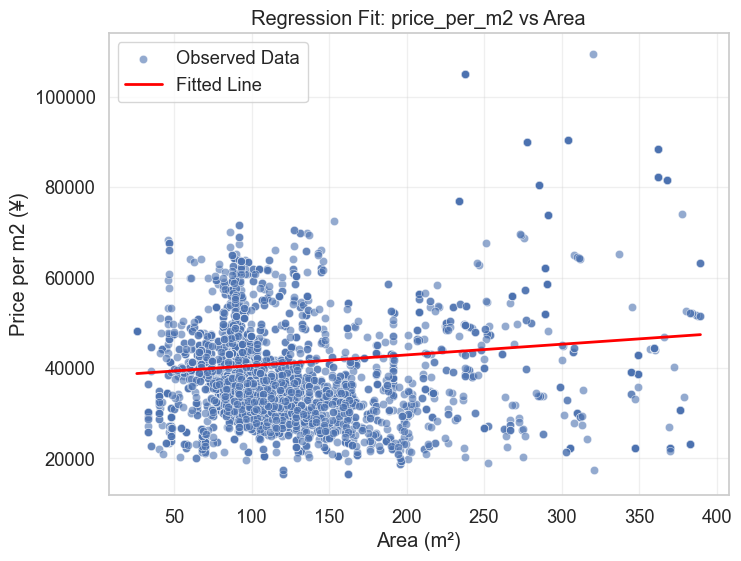

In [50]:
visualize_fit(sale_clean, model_price, "price_per_m2")

**Interpretation of Model 1 Regression Results**  
The regression model for price per square meter explains approximately **26.2%** of the variation in property prices per square meter, as indicated by the R-squared value of **0.262**, suggesting that while area and location factors contribute to price determination, other significant factors not included in the model likely influence property values as well.  
The constant term of **38,158** represents the baseline price per square meter in the reference location of **Huilongguan**. Properties in **Huoying** command a premium of **2,037 yuan** per square meter compared to Huilongguan, while **Shahe** properties are even more expensive with a **9,380 yuan** premium. Conversely, properties in **Tiantongyuan** show a substantial discount of **9,321 yuan** per square meter relative to Huilongguan, indicating significant location-based price disparities across these residential areas. Besides, the **area coefficient of 23.67** suggests that for every additional square meter, the price per square meter increases by about 23.7 yuan, a statistically significant but relatively modest effect.

In [51]:
# Build Model 2: Rent per m²
print("Model 2: Rent per m²")
model_rent, X_rent, y_rent = build_model(rent_clean, "rent_per_m2")

Model 2: Rent per m²

Key Regression Statistics: rent_per_m2:
R-squared: 0.4499
Adjusted R-squared: 0.4493
F-statistic: 810.05
P-value (F-stat): 0.0000
Number of observations: 3967

Model Coefficients:


,Coefficient,Std. Error,t-value,P>|t|
area,-0.225426,0.005338,-42.229235,4.248965e-322
block_huoying,-2.213137,0.796890,-2.777220,5.508399e-03
block_shahe,-21.951479,0.664512,-33.033984,1.352802e-211
block_tiantongyuan,-9.814410,0.673706,-14.567787,7.187342e-47
const,95.204543,0.637702,149.293261,0.000000e+00


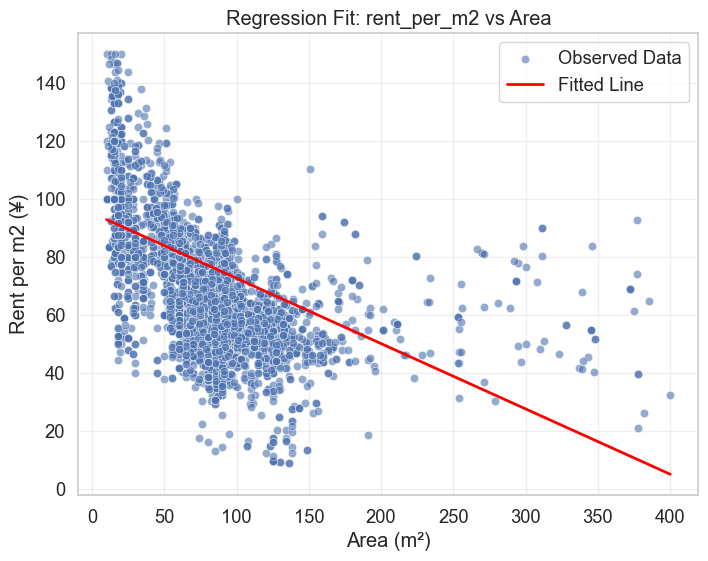

In [52]:
# Visualize Fitted Models
visualize_fit(rent_clean, model_rent, "rent_per_m2")

**Interpretation of Model 2 Regression Results**  
The rental price model demonstrates substantially better explanatory power than the sales price model, accounting for approximately **45.0%** of the variation in rental prices per square meter. This improved fit suggests that the included factors of **area and location** are more relevant for understanding rental market dynamics than they were for sales prices.  
The coefficient patterns reveal clear market dynamics, particularly the strong **negative relationship** between unit area and rental price per square meter. Each additional square meter corresponds to a **decrease of about 0.23 yuan** in the rental rate per square meter, reflecting an **economies-of-scale effect**—tenants pay proportionally less for larger apartments. The **baseline rental price** in **Huilongguan** stands at **95.20 yuan per square meter**, while **Shahe** shows the largest discount of **21.95 yuan** compared to Huilongguan. **Tiantongyuan** also exhibits a notable discount of **9.81 yuan**, and **Huoying** rents are **2.21 yuan lower** than Huilongguan. These results indicate strong spatial variations in rental prices, consistent with differing levels of accessibility and housing demand across subdistricts.

**Residual Analysis for Linear Models**

In [53]:
# Compute residuals
def compute_residuals(model, X, y):
    """
    Compute residuals and standardized residuals for the fitted model.
    """
    fitted_values = model.predict(X)
    residuals = y - fitted_values
    standardized_residuals = residuals / np.std(residuals)
    return residuals, standardized_residuals, fitted_values

In [54]:
# Perform residual diagnostics and visualize.
from statsmodels.stats.outliers_influence import OLSInfluence
def residuals_analysis(model, X, y, title_prefix=""):
    # Compute residuals
    fitted_values = model.fittedvalues
    residuals = y - fitted_values
    influence = OLSInfluence(model)
    standardized_residuals = influence.resid_studentized_internal
    leverage = influence.hat_matrix_diag
    
    # Identify ±3 standardized residuals
    outlier_mask = np.abs(standardized_residuals) > 3
    n_outliers = outlier_mask.sum()
    
    # Identify high leverage points (threshold 2*p/n)
    p = X.shape[1]  # number of predictors including constant
    n = X.shape[0]  # number of observations
    leverage_threshold = 2 * p / n
    high_leverage_mask = leverage > leverage_threshold
    n_high_leverage = high_leverage_mask.sum()
    
    # Identify influential points (both high leverage and large residual)
    influential_mask = outlier_mask & high_leverage_mask
    n_influential = influential_mask.sum()
    
    # Print summary
    print(f"\nResidual Analysis Summary: {title_prefix}")
    print(f"Total observations: {n}")
    print(f"Standardized residuals > |3|: {n_outliers}")
    print(f"High leverage points: {n_high_leverage}")
    print(f"Influential points (high leverage + large residual): {n_influential}")
    print(f"Leverage threshold (2*p/n): {leverage_threshold:.4f}")
    print(f"Residuals mean: {residuals.mean():.4f}, std: {residuals.std():.4f}")
    
    # Visualization
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 5))
    
    # 1. Residuals vs Fitted
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=fitted_values, y=residuals, alpha=0.6)
    plt.axhline(0, color="red", linestyle="--", linewidth=1)
    # Highlight high leverage points
    plt.scatter(fitted_values[high_leverage_mask], residuals[high_leverage_mask], 
                color="red", s=50, label="High leverage", alpha=0.8)
    # Highlight outliers
    plt.scatter(fitted_values[outlier_mask], residuals[outlier_mask],
                color="orange", s=50, label="Outliers", alpha=0.8)
    # Highlight influential points
    plt.scatter(fitted_values[influential_mask], residuals[influential_mask],
                color="purple", s=70, marker="*", label="Influential", alpha=0.9)
    
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.title(f"{title_prefix} Residuals vs Fitted")
    plt.legend()
    
    # 2. QQ Plot
    plt.subplot(1, 2, 2)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f"{title_prefix} QQ Plot (Normality Check)")
    
    plt.tight_layout()
    plt.show()
    
    # Return summary dictionary
    summary_dict = {
        "n_outliers": n_outliers,
        "n_high_leverage": n_high_leverage,
        "n_influential": n_influential,
        "leverage_threshold": leverage_threshold,
        "residuals_mean": residuals.mean(),
        "residuals_std": residuals.std()
    }
    return summary_dict


Residual Analysis Summary: Price per m²
Total observations: 3485
Standardized residuals > |3|: 20
High leverage points: 132
Influential points (high leverage + large residual): 0
Leverage threshold (2*p/n): 0.0029
Residuals mean: -0.0000, std: 12755.2588


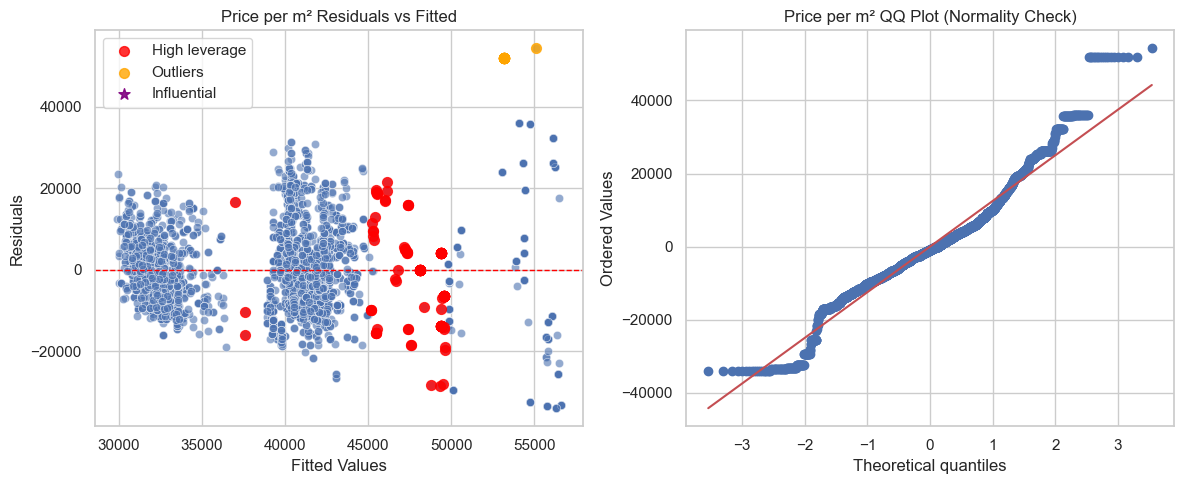

In [55]:
# Perform residual analysis
price_resid_summary = residuals_analysis(model_price, X_price, y_price, title_prefix="Price per m²")


Residual Analysis Summary: Rent per m²
Total observations: 3967
Standardized residuals > |3|: 77
High leverage points: 85
Influential points (high leverage + large residual): 35
Leverage threshold (2*p/n): 0.0025
Residuals mean: 0.0000, std: 15.8645


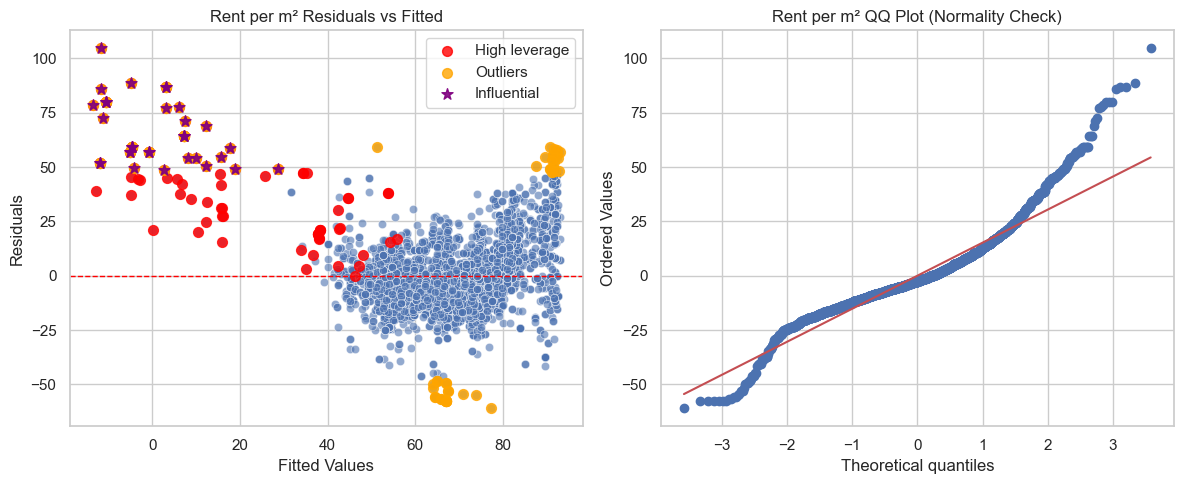

In [56]:
# Perform residual analysis
rent_resid_summary = residuals_analysis(model_rent, X_rent, y_rent, title_prefix="Rent per m²")

**Interpretation:**  
The residuals versus fitted values plot reveals that residuals are reasonably distributed around the zero line. However, the presence of numerous high leverage points and the large residual range indicate that certain observations in the predictor space exert disproportionate influence on the model estimates. The Q-Q plot demonstrates approximate normality in the central region with points following the diagonal line closely, but tails show upward curvature, indicating a heavy-tailed distribution.  
These diagnostic results collectively suggest that the model may benefit from incorporating nonlinear terms and interaction effects to better capture the complex relationships in the housing market data.

#### 3.2 Predict Values and Compute Price-to-Rent Ratio

In [57]:
def predict_and_compute_ratio_cross(sale_df, rent_df, model_price, model_rent):
    # Prepare predictors for both datasets
    X_sale = pd.get_dummies(sale_df[["area", "block"]], columns=["block"], drop_first=True)
    X_sale = sm.add_constant(X_sale)
    
    X_rent = pd.get_dummies(rent_df[["area", "block"]], columns=["block"], drop_first=True)
    X_rent = sm.add_constant(X_rent)
    
    # Cross-prediction
    sale_df_cross = sale_df.copy()
    rent_df_cross = rent_df.copy()
    
    # Predict rent prices for sale properties
    sale_df_cross["pred_rent_per_m2"] = model_rent.predict(X_sale)
    sale_df_cross["price_to_rent_ratio"] = sale_df_cross["price_per_m2"] / sale_df_cross["pred_rent_per_m2"]
    
    # Predict sale prices for rent properties  
    rent_df_cross["pred_price_per_m2"] = model_price.predict(X_rent)
    rent_df_cross["price_to_rent_ratio"] = rent_df_cross["pred_price_per_m2"] / rent_df_cross["rent_per_m2"]
    
    # Combine all ratios
    all_ratios = pd.concat([
        sale_df_cross[["block", "area", "price_to_rent_ratio"]],
        rent_df_cross[["block", "area", "price_to_rent_ratio"]]
    ], ignore_index=True)
    
    # Calculate block-level statistics
    block_stats = all_ratios.groupby("block")["price_to_rent_ratio"].agg([
        ("median", "median"),
        ("mean", "mean"), 
        ("std", "std"),
        ("count", "count")
    ]).reset_index()
    
    print(f"\nPrice to rent ratio prediction results:")
    print(f"Total observations: {len(all_ratios)}")
    print(f" - From sale data: {len(sale_df_cross)}")
    print(f" - From rent data: {len(rent_df_cross)}")
    print("\nBlock-level Price-to-Rent Ratios:")
    
    for _, row in block_stats.iterrows():
        print(f"{row['block']:15} | Median: {row['median']:7.1f} | "
              f"Mean: {row['mean']:7.1f} | Std: {row['std']:5.1f} ")
    
    return block_stats, all_ratios

In [58]:
# Predict and compute ratio
block_stats, all_ratios = predict_and_compute_ratio_cross(sale_data_clean, rent_data_clean, model_price, model_rent)


Price to rent ratio prediction results:
Total observations: 7708
 - From sale data: 3511
 - From rent data: 4197

Block-level Price-to-Rent Ratios:
huilongguan     | Median:   546.3 | Mean:   665.9 | Std: 703.1 
huoying         | Median:   569.9 | Mean:   592.0 | Std: 248.2 
shahe           | Median:   926.1 | Mean:   988.5 | Std: 4721.5 
tiantongyuan    | Median:   536.9 | Mean:   589.5 | Std: 457.6 


#### 3.3 Visualization: Figure B (Median Ratio by Block)

In [59]:
def plot_ratio_by_block(block_ratio):
    """Bar plot of median price-to-rent ratio by block."""
    plt.figure(figsize=(10, 6))
    sns.barplot(x="block", y="median_pred_ratio", data=block_ratio, palette="Blues_d")
    plt.axhline(y=200, color="red", linestyle="--", label="Global Fair Value ≈ 200")
    plt.title("Figure B: Median Predicted Price-to-Rent Ratio by Block")
    plt.xlabel("Block")
    plt.ylabel("Predicted Price-to-Rent Ratio (Monthly)")
    plt.legend()
    plt.tight_layout()
    plt.show()

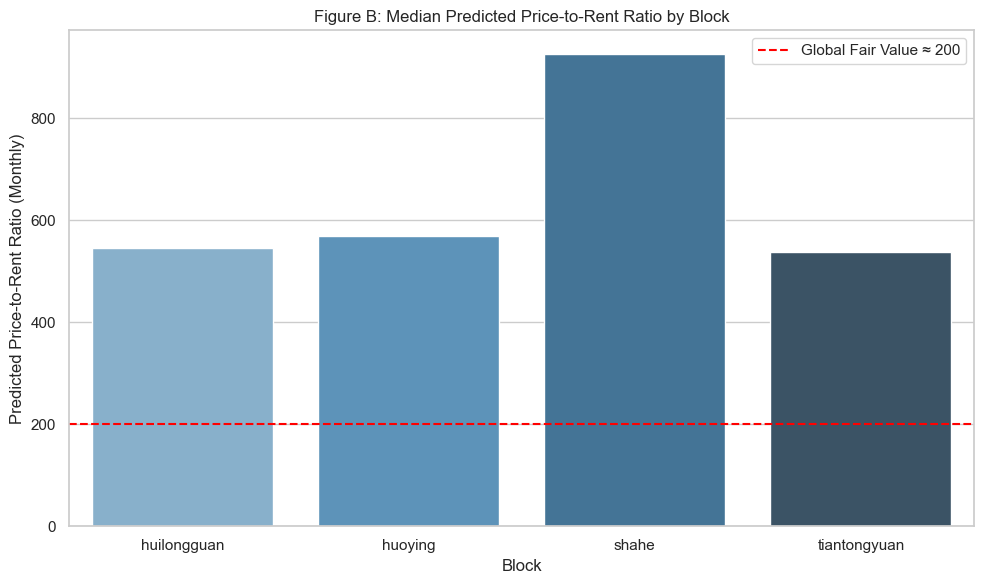

In [60]:
# get median
block_ratio_for_plot = block_stats[["block", "median"]].copy()
block_ratio_for_plot = block_ratio_for_plot.rename(columns={"median": "median_pred_ratio"})

# Plot result
plot_ratio_by_block(block_ratio_for_plot)

### 4 Enhanced Models

#### 4.1 Build Models

$$y_i = \beta_0 + \beta_1 \cdot \text{area}_i + \beta_2 \cdot \text{area}_i^2 
      + \sum_{j=1}^{k-1} \gamma_j \cdot \text{block}_{i,j} 
      + \sum_{j=1}^{k-1} \delta_j \cdot (\text{area}_i \cdot \text{block}_{i,j}) 
      + \epsilon_i$$

In [61]:
# Function to build enhanced linear model
def build_enhanced_model(df, target_col):
    # Prepare predictor matrix
    X = df[["area", "block"]].copy()
    
    # Non-linear term: area^2
    X["area_sq"] = X["area"] ** 2

    # Convert categorical variable 'block' into dummy variables
    X = pd.get_dummies(X, columns=["block"], drop_first=True)
    
    # Interaction terms: area * block
    block_cols = [col for col in X.columns if col.startswith("block_")]
    for block in block_cols:
        X[f"area_x_{block}"] = X["area"] * X[block]
    
    # Add constant term (intercept)
    X = sm.add_constant(X).astype(float)
    
    # Define dependent variable
    y = df[target_col].astype(float)
    
    # Fit the OLS regression model
    model = sm.OLS(y, X).fit()
    
    # Display key model information
    print(f"\n=== Enhanced Model Summary: {target_col} ===")
    print(f"R-squared: {round(model.rsquared, 4)}")
    print(f"Adjusted R-squared: {round(model.rsquared_adj, 4)}")
    print(f"F-statistic: {round(model.fvalue, 2)}")
    print(f"P-value (F-stat): {model.f_pvalue:.4f}")
    print(f"Number of observations: {int(model.nobs)}")
    
    # Display model coefficients
    coef_table = pd.DataFrame({
        "Coefficient": model.params,
        "Std. Error": model.bse,
        "t-value": model.tvalues,
        "P>|t|": model.pvalues
    }).sort_index()
    print("\n=== Model Coefficients ===")
    display(coef_table)
    
    return model, X, y

In [62]:
# Model 1+: Price per m²
model_price_plus, X_price_plus, y_price_plus = build_enhanced_model(sale_clean, "price_per_m2")


=== Enhanced Model Summary: price_per_m2 ===
R-squared: 0.3019
Adjusted R-squared: 0.3003
F-statistic: 187.87
P-value (F-stat): 0.0000
Number of observations: 3485

=== Model Coefficients ===


,Coefficient,Std. Error,t-value,P>|t|
area,202.968972,13.816240,14.690608,1.904620e-47
area_sq,-0.463500,0.036262,-12.782015,1.360489e-36
area_x_block_huoying,-49.770326,15.173518,-3.280078,1.048017e-03
area_x_block_shahe,24.431383,7.870143,3.104313,1.922561e-03
area_x_block_tiantongyuan,-57.058093,9.000865,-6.339179,2.606893e-10
block_huoying,7637.917322,1650.198086,4.628485,3.818115e-06
block_shahe,6315.483912,1414.640456,4.464374,8.285386e-06
block_tiantongyuan,-3148.921152,1286.827746,-2.447042,1.445260e-02
const,25243.398034,1139.382034,22.155341,7.592154e-102


In [63]:
# Model 2+: Rent per m²
model_rent_plus, X_rent_plus, y_rent_plus = build_enhanced_model(rent_clean, "rent_per_m2")


=== Enhanced Model Summary: rent_per_m2 ===
R-squared: 0.6666
Adjusted R-squared: 0.6659
F-statistic: 989.26
P-value (F-stat): 0.0000
Number of observations: 3967

=== Model Coefficients ===


,Coefficient,Std. Error,t-value,P>|t|
area,-0.671630,0.011634,-57.730374,0.000000e+00
area_sq,0.001483,0.000041,36.151012,1.512346e-247
area_x_block_huoying,0.041157,0.018642,2.207792,2.731589e-02
area_x_block_shahe,0.102056,0.012351,8.263296,1.912124e-16
area_x_block_tiantongyuan,0.051403,0.011387,4.514304,6.537233e-06
block_huoying,-5.589345,1.521852,-3.672727,2.431475e-04
block_shahe,-31.587415,1.140416,-27.698154,1.685072e-154
block_tiantongyuan,-13.716102,1.096657,-12.507190,3.134840e-35
const,118.871372,0.829851,143.244273,0.000000e+00


**Interpretation:**  
The enhanced regression models show substantial improvements in explanatory power after adding nonlinear and interaction terms. The sales price model explains 30.2% of price variation, while the rental model achieves an R² of 0.667, indicating much stronger explanatory capacity than the basic linear models.  
In the sales market, the positive coefficient for area (202.97) and negative coefficient for area² (-0.46) confirm a diminishing marginal effect of size—larger units add less value per square meter. Significant interaction effects further reveal spatial heterogeneity: the marginal value of area differs by subdistrict, being lower in Huoying and Tiantongyuan and higher in Shahe. Location premiums are evident, with Huoying and Shahe showing notable positive base effects (7,638 yuan and 6,315 yuan above baseline), while Tiantongyuan shows a moderate discount (-3,149 yuan).  
In contrast, the rental model indicates a nonlinear and location-sensitive pattern: rents per m² decline with size (–0.67) but slightly rebound for very large units due to the positive quadratic term (0.0015). Spatial differences are strong—Shahe rents are about 31.6 yuan lower than the baseline, followed by Tiantongyuan (–13.7 yuan) and Huoying (–5.6 yuan). The high R² for rentals suggests more systematic pricing and tighter spatial consistency compared to the more heterogeneous sales market.

**Reason for higher R²:**  
The improved model includes nonlinear and interaction terms, allowing it to capture more complex relationships between features.
As a result, it explains a larger proportion of the variance in housing prices and rents, leading to a higher R² value.

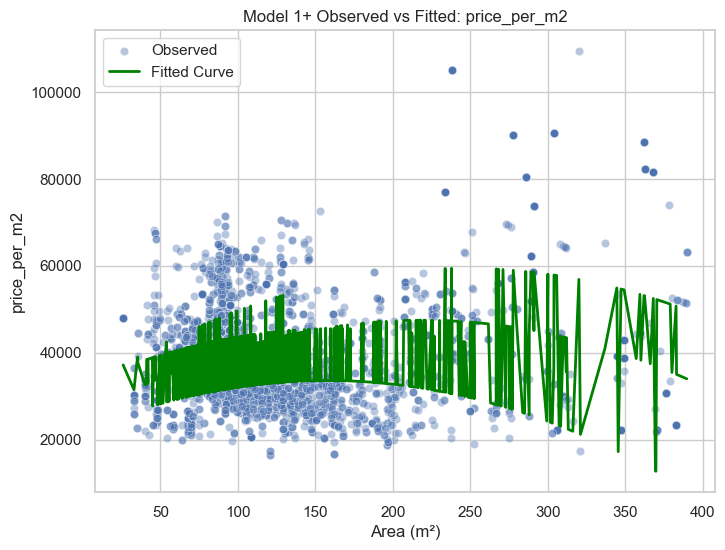

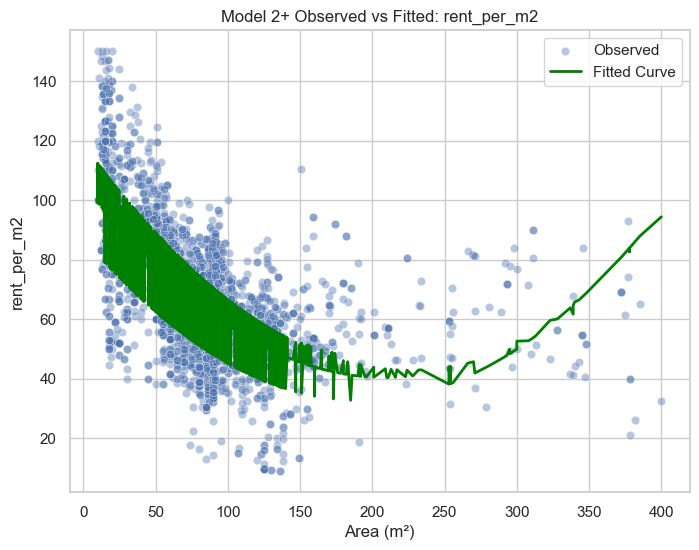

In [64]:
# Visualization Function for Enhanced Models
def plot_enhanced_model_fit(df, model, target_col, title_prefix=""):
    """
    Visualize observed vs fitted relationship between area and target variable
    for the enhanced model including non-linear and interaction terms.
    """
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    import statsmodels.api as sm

    # Rebuild X matrix with the same structure as used in the enhanced model
    X = df[["area", "block"]].copy()
    X["area_sq"] = X["area"] ** 2
    X = pd.get_dummies(X, columns=["block"], drop_first=True)
    block_cols = [col for col in X.columns if col.startswith("block_")]
    for block in block_cols:
        X[f"area_x_{block}"] = X["area"] * X[block]
    X = sm.add_constant(X).astype(float)

    # Predicted values
    y_pred = model.predict(X)

    # Plot observed scatter and fitted curve
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df["area"], y=df[target_col], alpha=0.4, label="Observed")

    # To make the fitted line smoother, plot average predicted values by area
    sort_idx = np.argsort(df["area"])
    plt.plot(df["area"].iloc[sort_idx], y_pred.iloc[sort_idx],
             color="green", linewidth=2, label="Fitted Curve")

    plt.xlabel("Area (m²)")
    plt.ylabel(target_col)
    plt.title(f"{title_prefix} Observed vs Fitted: {target_col}")
    plt.legend()
    plt.show()

# Price per m² (Model 1+)
plot_enhanced_model_fit(sale_clean, model_price_plus, "price_per_m2", "Model 1+")

# Rent per m² (Model 2+)
plot_enhanced_model_fit(rent_clean, model_rent_plus, "rent_per_m2", "Model 2+")

#### 4.2 Predict using enhanced models and calculate price-to-rent ratio

In [65]:
def predict_and_compute_ratio_cross_plus(sale_df, rent_df, model_price, model_rent):
    """
    Cross-predict price-to-rent ratios using enhanced models with multiple predictors.
    Ensures feature alignment between training and prediction data.
    """
    # Extract training features used in each model
    price_features = model_price.model.exog_names  # includes 'const'
    rent_features = model_rent.model.exog_names
    
    # Prepare predictors for both datasets, aligned with model features
    # For sale data predicting rent
    X_sale = sm.add_constant(sale_df, has_constant='add')
    X_sale = X_sale.reindex(columns=rent_features, fill_value=0)
    
    # For rent data predicting sale price
    X_rent = sm.add_constant(rent_df, has_constant='add')
    X_rent = X_rent.reindex(columns=price_features, fill_value=0)
    
    # Cross-prediction
    sale_df_cross = sale_df.copy()
    rent_df_cross = rent_df.copy()
    
    # Predict rent for sale data
    sale_df_cross["pred_rent_per_m2"] = model_rent.predict(X_sale)
    sale_df_cross["price_to_rent_ratio"] = (
        sale_df_cross["price_per_m2"] / sale_df_cross["pred_rent_per_m2"]
    )
    
    # Predict price for rent data
    rent_df_cross["pred_price_per_m2"] = model_price.predict(X_rent)
    rent_df_cross["price_to_rent_ratio"] = (
        rent_df_cross["pred_price_per_m2"] / rent_df_cross["rent_per_m2"]
    )
    
    # Combine and compute summary statistics
    all_ratios = pd.concat([
        sale_df_cross[["block", "area", "price_to_rent_ratio"]],
        rent_df_cross[["block", "area", "price_to_rent_ratio"]]
    ], ignore_index=True)
    
    block_stats = all_ratios.groupby("block")["price_to_rent_ratio"].agg([
        ("median", "median"),
        ("mean", "mean"),
        ("std", "std"),
        ("count", "count")
    ]).reset_index()
    
    # Display summary
    print(f"\n[Enhanced Model] Price-to-Rent Ratio Prediction Summary:")
    print(f"Total observations: {len(all_ratios)}")
    print(f" - From sale data: {len(sale_df_cross)}")
    print(f" - From rent data: {len(rent_df_cross)}")
    
    print("\nBlock-level Ratios:")
    for _, row in block_stats.iterrows():
        print(f"{row['block']:15} | Median: {row['median']:7.1f} | "
              f"Mean: {row['mean']:7.1f} | Std: {row['std']:5.1f}")
    
    return block_stats, all_ratios


[Enhanced Model] Price-to-Rent Ratio Prediction Summary:
Total observations: 7708
 - From sale data: 3511
 - From rent data: 4197

Block-level Ratios:
huilongguan     | Median:   622.9 | Mean:   529.9 | Std: 1170.2
huoying         | Median:   586.6 | Mean:   679.1 | Std: 1337.7
shahe           | Median:   695.7 | Mean:   466.7 | Std: 812.0
tiantongyuan    | Median:   685.9 | Mean:   577.6 | Std: 6302.7


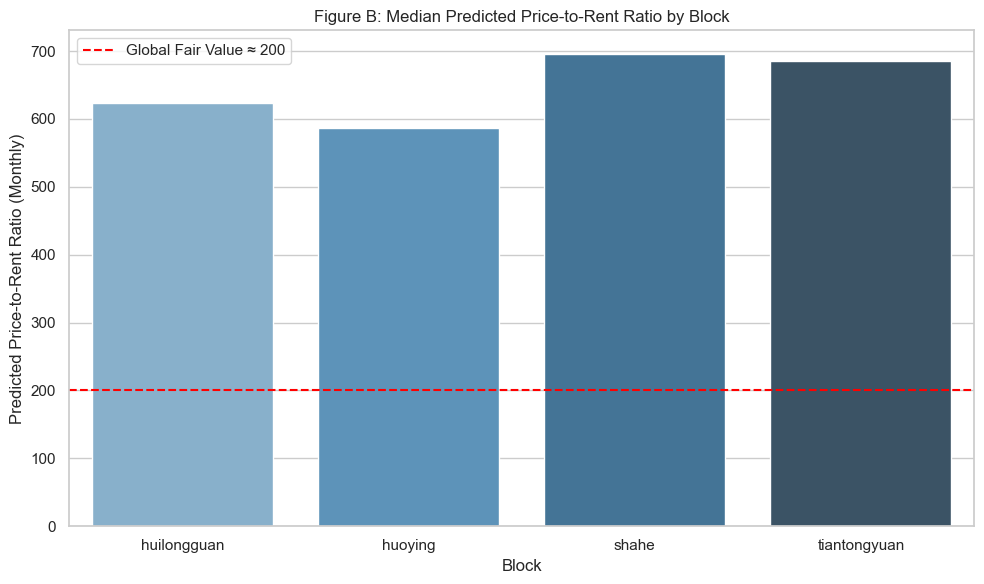

In [66]:
# Predict and compute ratio
block_stats_plus, all_ratios_plus = predict_and_compute_ratio_cross_plus(sale_data_clean, rent_data_clean, model_price_plus, model_rent_plus)
# get median
block_ratio_for_plot_plus = block_stats_plus[["block", "median"]].copy()
block_ratio_for_plot_plus = block_ratio_for_plot_plus.rename(columns={"median": "median_pred_ratio"})

# Plot result
plot_ratio_by_block(block_ratio_for_plot_plus)

#### 4.3 Compare Price-to-Rent Ratios from Three Methods

In [67]:
# Method 1: Median ratio
median_ratio_df = (
    block_ratio[["block", "price_to_rent_ratio"]]
    .rename(columns={"price_to_rent_ratio": "Median Ratio"})
)

# Method 2: Linear model
linear_model_df = (
    block_stats[["block", "median"]]
    .rename(columns={"median": "Linear Model"})
)

# Method 3: Nonlinear (enhanced) model
nonlinear_model_df = (
    block_stats_plus[["block", "median"]]
    .rename(columns={"median": "Nonlinear Model"})
)

# Merge the three results by "block"
comparison_df = (
    median_ratio_df
    .merge(linear_model_df, on="block", how="outer")
    .merge(nonlinear_model_df, on="block", how="outer")
)

print("Comparison of Price-to-Rent Ratios from Three Methods:\n")
display(comparison_df)

Comparison of Price-to-Rent Ratios from Three Methods:



,block,Median Ratio,Linear Model,Nonlinear Model
0,huilongguan,524.986110,546.275262,622.863449
1,huoying,564.002578,569.911752,586.551635
2,shahe,929.487179,926.091284,695.658896
3,tiantongyuan,526.233113,536.892022,685.850911


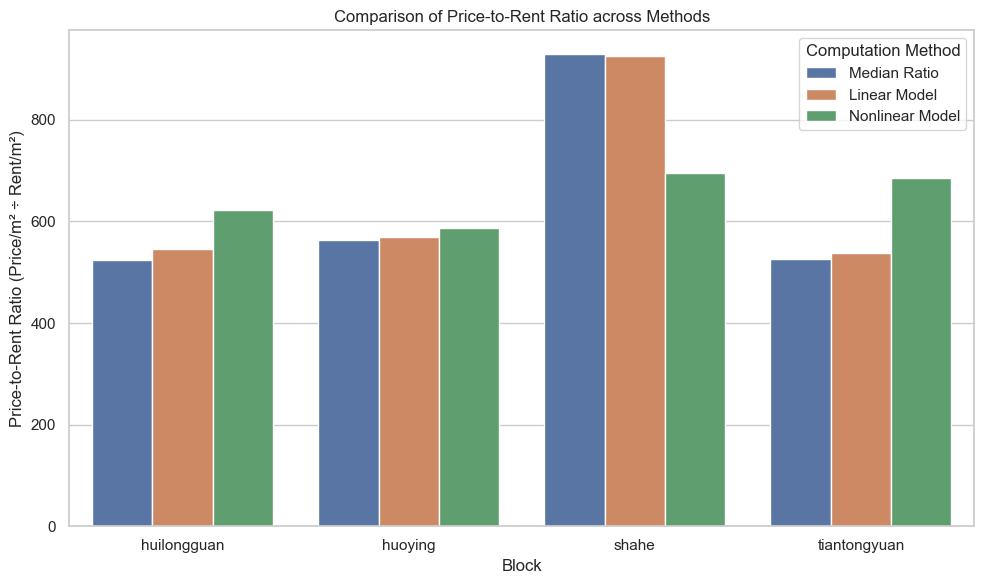

In [68]:
# Bar Plot Comparison
plt.figure(figsize=(10, 6))
comparison_df_melted = comparison_df.melt(id_vars="block", 
                                          var_name="Method", 
                                          value_name="Price-to-Rent Ratio")

sns.barplot(data=comparison_df_melted, x="block", y="Price-to-Rent Ratio", hue="Method")
plt.title("Comparison of Price-to-Rent Ratio across Methods")
plt.xlabel("Block")
plt.ylabel("Price-to-Rent Ratio (Price/m² ÷ Rent/m²)")
plt.legend(title="Computation Method")
plt.tight_layout()
plt.show()

**Conclusion:**  
Method 2 (Linear Model) is recommended because it fully utilizes all the data points (around 4000) while maintaining strong consistency with the median method. It provides the optimal balance between statistical power and model reliability, avoiding the overfitting risks of the nonlinear approach.